In [ ]:
# Run this cell and restart the kernel so it loads properly
!python -m spacy download en_core_web_md

In [1]:
# Root path for accessing and storing files
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/5137'

In [2]:
# Optionally Setup GPU use
import tensorflow as tf
DEVICE_NAME = tf.test.gpu_device_name()
if DEVICE_NAME != '/device:GPU:0':
  DEVICE_NAME = '/cpu:0'
  print('GPU device not found... using CPU')
print('Found GPU at: {}'.format(DEVICE_NAME))

Found GPU at: /device:GPU:0


# Pre-Execution

## Imports

In [35]:
import numpy as np
import pandas as pd
import nltk
import math
import spacy
import csv
import random
import timeit
import time 
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import PCA

from sklearn.feature_selection import f_classif 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

from keras.preprocessing.text import Tokenizer

from scipy import stats

from imblearn.under_sampling import RandomUnderSampler

In [4]:
# NLTK Downloads
from nltk.corpus import wordnet as wn
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
# Load Spacy
nlp = spacy.load('en_core_web_md')

## Data Import and Cleaning

In [6]:
# Import the contract text
import json

data_path = f'{ROOT_PATH}/data/CUADv1.json'
with open(data_path) as json_file:
    contract_data = json.load(json_file)

In [9]:
# train_path = f'{ROOT_PATH}/data/train_separate_questions.json'
# with open(train_path) as json_file:
#     train_data = json.load(json_file)

In [8]:
# Elements to extract from CUAD set
element_id_list = [0, 1, 2, 31, 33]
# 0: Contract name
# 1: Parties
# 2: Agreement Date
# 31: Source code escrow
# 33: Audit rights

element_dict = {
    0: 'Contract Name',
    1: 'Parties',
    2: 'Agreement Date',
    31: 'Source Code Escrow',
    33: 'Audit Rights'
}

element_map = {
    0: 0,
    1: 1,
    2: 2,
    31: 5,
    33: 6
}

## Parsing and Cleaning

In [10]:
# Retrieve and parse a contract to extract needed information
def get_contract_by_id(contract_id):
  contracts = contract_data['data'] # list (510 contracts)

  contract = contracts[contract_id] # dict (title, paragraphs)
  contract_title = contract['title'] # string
  paragraphs = contract['paragraphs'] # list

  paragraph = paragraphs[0] # dict (qas, context)

  qas = paragraph['qas'] # list (41 questions - each type)

  # Extract only the qas that matter here (choose the ids)
  new_qas = []
  element_qas = [(i,q) for i,q in enumerate(qas) if i in element_id_list]
  for i,q in element_qas: # Will filter this down to just the ones we want
    answers = []
    for a in q['answers']:
      new_a = {
          'text': a['text'],
          'start_ind': a['answer_start'],
          'end_ind': a['answer_start'] + len(a['text'])
      }
      answers.append(new_a)
    
    # This may need to get structured as a category-val dict...?
    new_qa = {
          'id': q['id'],
          'category': element_dict[i],
          'question': q['question'],
          'is_impossible': q['is_impossible'],
          'answers': answers
    }
    new_qas.append(new_qa)

  # get the context and qas
  return {
      'id': contract_id,
      'title': contract_title,
      'context': paragraph['context'],
      'qas': new_qas
  }

In [11]:
def print_contract(contract, text_len=200):
  # Num answerable qs
  possible_answers = [x['id'] for x in contract['qas'] if x['is_impossible'] == False]

  # Print info
  print('\nContract ID:', contract['id'])
  print('\nTitle:', contract['title'])
  print('\n------------------')
  print(contract['context'][0:text_len])
  print('\n------------------')
  for qa in contract['qas']:
    answer_texts = [a['text'] for a in qa['answers']]
    print(f'{qa["category"]:25} {" ".join(answer_texts)}')
    
  print('\n============================')

## Features

### Hand-crafted Features

In [12]:
# Helpers
def contains_num(s):
    return any(i.isdigit() for i in s)

def print_feats(doc, feats):
    rep_str = '{:<6} '*len(feats[0])
    rep_str = '{:<20}' + rep_str
    for i,f in enumerate(feats):
        text = doc[i].text
        print(rep_str.format(text, *f))

In [13]:
upos = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']

all_deps = ['ROOT', 'nummod', '', 'compound', 'dobj', 'punct', 'det', 'nsubjpass', 'auxpass', 'agent', 'cc', 'conj', 'pobj', 'nmod', 'appos', 'prep', 'amod', 'poss', 'case', 'nsubj', 'advmod', 'pcomp', 'relcl', 'aux', 'oprd', 'mark', 'advcl', 'acl', 'neg', 'ccomp', 'xcomp', 'attr', 'dep', 'npadvmod', 'meta', 'acomp', 'preconj', 'prt', 'intj', 'expl', 'dative', 'predet', 'csubj', 'parataxis', 'quantmod', 'csubjpass']

keyword_sets = [
  ['agreement', 'license', 'sponsorship', 'distributor', 'joint', 'strategic', 'alliance', 'endorsement', 'content', 'maintenance'],
  ['inc', 'llc', 'ltd', 'company', 'parties', 'party', 'distributor', 'collectively', 'corporation', 'management'],
  ['laws', 'agreement', 'state', 'shall', 'governed', 'accordance', 'construed', 'law', 'principles'],
  ['company', 'rights', 'right', 'property', 'title', 'shall', 'intellectual', 'agreement', 'interest'],
  ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december'],
  ['shall', 'records', 'reasonable', 'business', 'audit' ]
]

def get_handcrafted_features(doc):
    all_feats = []

    for token in doc:
        features = []
        text = token.text
        isalpha = text.isalpha()

        # binary feature for all uppercase
        f1 = isalpha and text.isupper()
        # binary feature for all lowercase
        f2 = isalpha and text.islower()
        # binary feature for mixed-case
        f3 = isalpha and text != text.lower() and text != text.upper()
        # binary feature - is it a number?
        f4 = contains_num(text)

        features.extend([f1,f2,f3,f4])

        # Length features. Is it 1-2 chars? 3-4? 5-6? 7-8? 9-10? 11-12? 12+?
        l = len(text)

        for i in range(6):
          next_feat = l > 2*i and l <= (2*i)+2
          features.append(next_feat)
        
        features.append(l > 12)

        # Special features
        ## Is numeric
        f5 = text.isnumeric()
        features.append(f5)

        ## Special character
        f6 = l == 1 and not text.isalpha() and not text.isnumeric()
        features.append(f6)

        ## Stop-word
        f7 = text in nlp.Defaults.stop_words
        features.append(f7)

        # one-hot encode the pos types
        for up in upos:
          fp = 1 if token.pos_ == up else 0
          features.append(fp)

        # Check the keyword sets
        for ks in keyword_sets:
          f8 = text in ks
          features.append(f8)
        
        # one-hot encode the dependency types (Removed)
        # for dep in all_deps:
        #   fp = 1 if token.dep_ == dep else 0
        #   features.append(fp)

        all_feats.append(features)

    all_feats = np.array(all_feats)
    all_feats = all_feats.astype(int)

    return all_feats


### Feature Construction

In [14]:
# Find the token spans of the answers
def get_answer_spans(doc, answers):
  t_spans = []
  for ans in answers:
    start_ind = ans['start_ind']
    end_ind = ans['end_ind']
  
    # get token start and end
    tokens_a = [t.i for t in doc if t.idx >= start_ind]
    tokens_b = [t.i for t in doc if t.idx <= end_ind]
    t_span = [value for value in tokens_a if value in tokens_b]
    t_spans.append(t_span)
  
  return t_spans

In [15]:
# Get the embedding vectors for all tokens in a contract
def get_embedding_vectors(tokenizer, embedding_matrix, doc, t, window_offset = 3):
  # Result will be a long flat 1D vector of size v_dim x window_size
  res = []

  n_dim = len(embedding_matrix[0])

  for k in range(-window_offset, window_offset+1):
    target = t.i + k

    vec = np.zeros(n_dim)

    if target > 0 and target < len(doc):
      text = doc[target].text.lower()

      if text in tokenizer.word_index:
        tok = tokenizer.word_index[text]
        vec = embedding_matrix[tok]

    res.extend(vec)
  
  return res

In [16]:
# Extract a sliding window from the list of hand-crafted features
def get_hcf_vecs(hcf, t, window_offset=5):
  default_len = len(hcf[0])

  res = []

  for j in range(-window_offset, window_offset+1):
    target = t.i + j
    if target >= 0 and target < len(hcf):
      res.extend(hcf[target])
    else:
      res.extend(np.zeros(default_len))
  
  return res


In [17]:
# Get all of the features from a contract document
## Concats the window of hand-crafted features with the window of embedding vecs
def get_features(tokenizer, embedding_matrix, doc, do_hcf=True, do_emb=True):
  hcf = get_handcrafted_features(doc)
  def_len = len(hcf[0])

  all_fv = []

  # Full size will be 2*x + 1
  embedding_window_offset = 5
  hcf_window_offset = 5

  for t in doc:
    # Feature vector
    fv = []

    # Get the vector embeddings in sliding window
    if do_emb:
      emb_vecs = get_embedding_vectors(tokenizer, embedding_matrix, doc, t, embedding_window_offset)
      fv.extend(emb_vecs)

    # Get HCF vectors 
    if do_hcf:
      hcf_vecs = get_hcf_vecs(hcf, t, hcf_window_offset)
      fv.extend(hcf_vecs)
    
    fv = np.array(fv)
    all_fv.append(fv)

  return all_fv

In [18]:
# Get the target labels from a contract document
def get_labels(contract, element_id, doc):
  labels = []

  qa = contract['qas'][element_id]

  # Get the span of the answer tokens
  # Concatenate together so we have a list of tokens that are part of the label
  answers = qa['answers']
  answer_spans = get_answer_spans(doc, answers)
  concat_ans_spans = np.concatenate(answer_spans) if len(answer_spans) > 0 else []
  
  for t in doc:
    # Get the label
    if t.i in concat_ans_spans:
      labels.append(1)
    else:
      labels.append(0)
  
  return labels

## Pre-Processing

### Filter and Tokenize Contracts

In [19]:
# Get all the contracts and nlp docs.. This operation takes about 3 minutes
def get_contracts_and_docs(max_doc_length=100000):
  all_contracts = []
  nlp_set = []

  for i in range(510):
    next_contract = get_contract_by_id(i) 

    if len(next_contract['context']) < max_doc_length:
      all_contracts.append(next_contract)
      nlp_set.append(nlp(next_contract['context']))
  
    if i%20==0: print(i)
  print('Total Contracts:', len(all_contracts))

  return all_contracts, nlp_set


In [21]:
# Get all contracts that contain a specified element
def get_contracts_docs_with_element(contracts, docs, element_id):
  new_contracts = []
  new_docs = []
  for i,c in enumerate(contracts):
    answers = c['qas'][element_id]['answers']
    if len(answers) > 0:
      new_contracts.append(c)
      new_docs.append(docs[i])
  return new_contracts, new_docs


### Embeddings

In [22]:
# Get the pre-trained embedding and build the tokenizer
def get_embeddings_and_tokenizer(all_contracts, embedding_size=50):
  assert(embedding_size in [50,100,200,300])
  tokenizer = Tokenizer()

  texts = [c['context'].lower() for c in all_contracts]

  tokenizer.fit_on_texts(texts)

  # Bring in embedding
  glove_path = f'{ROOT_PATH}/glove/glove.6B.{embedding_size}d.txt'
  embeddings_index = dict()
  f = open(glove_path)
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_index))

  vocab_size = len(tokenizer.word_index)
  print('Vocab size:', vocab_size)

  # Build embedding matrix - probably store this...
  embedding_matrix = np.zeros((vocab_size+1, embedding_size))
  for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  
  return embedding_matrix, tokenizer


### Build Features for Element

In [23]:
# Token windows to look for each element
doc_ranges = [
  [0,1000],
  [0,1600],
  [0,3000],
  [300,13000],
  [400,12000]
]

# Flags to use hand-crafted features and embeddings
do_hcf = True
do_emb = True

# Get all features and labels for an element
## This function can take a long time on a large dataset
def get_features_labels_for_element(contracts, docs, tokenizer, embedding_matrix, element_id):
  doc_range = doc_ranges[element_id]

  features = []
  labels = []

  for i, contract in enumerate(contracts):
    doc = docs[i]
    doc_sub = doc[doc_range[0]: doc_range[1]]
  
    next_fv = get_features(tokenizer, embedding_matrix, doc_sub, do_hcf, do_emb)
    next_labels = get_labels(contract, element_id, doc_sub)
    
    features.extend(next_fv)
    labels.extend(next_labels)
    if i%10==0: print(i)
  
  return features, labels

### Saving

In [24]:
import pickle

def save_obj(obj, filename):
  save_path = f'{ROOT_PATH}/stored/{filename}.pkl'
  with open(save_path, 'wb') as f:
    pickle.dump(obj, f)
  print('Saved')

def load_obj(filename):
  load_path = f'{ROOT_PATH}/stored/{filename}.pkl'
  with open(load_path, 'rb') as f:
    obj = pickle.load(f)
  return obj


## Execution Helpers

In [25]:
# Split data into folds
def get_k_folds(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
    skf.get_n_splits(X,y)

    result = []
    
    for train_index, test_index in skf.split(X,y):
        result.append({ "train": train_index, "test": test_index })
    
    return result

In [27]:
# Evaluate a model using test and pred sets
## Accuracy, precision, recall, f1, runtime
def evaluate(y_test, y_pred, runtime):
  cf = metrics.classification_report(y_test, y_pred)
  #print(cf)
  
  scores = metrics.precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
  acc = metrics.accuracy_score(y_test, y_pred)

  result = {
      'acc': round(acc,3),
      'prec': round(scores[0],3),
      'rec': round(scores[1],3),
      'f1': round(scores[2],3),
      'rt': round(runtime)
  }

  return result

In [28]:
# Process a set of model results 
def process_results(models, results):
  final_res = {}

  for model in models:    
    model_res = {}
    # prob add runtime here too
    for key in ['acc', 'prec', 'rec', 'f1', 'rt']:
      model_res[key] = round(results[model][key], 3)

    final_res[model] = model_res

  return final_res

def avg_round(lst):
  return round(sum(lst) / len(lst), 3)

In [29]:
# Process a list of results into average values
def process_iter_results(models, results):
  final_res = {}

  for model in models:
    model_res = {}

    for key in ['acc', 'prec', 'rec', 'f1', 'rt']:
      all_vals = [x[model][key] for x in results]
      model_res[key] = avg_round(all_vals)
    
    final_res[model] = model_res

  return final_res

In [27]:
# Print a result set
def print_results(results):
  print('\n')
  for k in results.keys():
    print('\n')
    print(k)
    for m in results[k].keys():
      print(f'{m}: {results[k][m]}')

In [31]:
# Run and time a model
def run_model(model, X_train, X_test, y_train, y_test):
  start = timeit.default_timer()
  model.fit(X_train, y_train)

  stop = timeit.default_timer()
  runtime = (stop - start)

  y_pred = model.predict(X_test)

  return evaluate(y_test, y_pred, runtime)

In [32]:
# Run a single iteration of a model
def execute(model_set, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)

  # Scale the data
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  results = {}

  for m in model_set.keys():
    print('running: ', m)
    model = model_set[m]
    results[m] = run_model(model, X_train, X_test, y_train, y_test)
  
  return results



## Design

### Dimensionality Reduction


In [34]:
# Feature selection
def select_features(X, y, percentile, do_print=False):
  fs = SelectPercentile(score_func=chi2, percentile=percentile)
  X_sel = fs.fit_transform(X, y)

  # Print
  # Show the feature rankings
  if do_print:
    print('Feature ranking:')
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))

    print('\nNumerical data sample:')
    print(X[0:2])
    print('\nSelected numerical data sample:')
    print(X_sel[0:2])

  return X_sel

In [31]:
# PCA
def perform_pca(X, percent=0.97):
  print('init', len(X[0]))
  #nc = int(len(X[0])*0.75)
  pca = PCA(n_components=percent, svd_solver='full')

  new_X = pca.fit_transform(X)
  print('new', len(new_X[0]))
  return new_X, pca

### Class Imbalance

In [36]:
# Smote underbalancing
def undersample(X, y, percent=0.1):

  u,c = np.unique(y, return_counts=True)
  print(u,c, len(X))
  
  # fit and apply the transform
  try:
    sm = RandomUnderSampler(sampling_strategy=percent)
    newX, newY = sm.fit_resample(X, y)
  except:
    print('** Sampling error...')
    newX = np.copy(X)
    newY = np.copy(y)

  u,c = np.unique(newY, return_counts=True)
  print(u,c, len(newX))

  return newX, newY

## Stats

In [37]:
# Run a statistical test on fold results
## Performs Friedman or Wilcoxon signed-rank (if n = 2)
def run_stats(all_results, metric_name):
    print('--Stat test:', metric_name)
    all_models = all_results[0].keys()
    n = len(all_models) # num algs
    num_folds = len(all_results) # num folds

    a = np.zeros((n, num_folds))
    wa = np.zeros((n, num_folds))
    rank_sums = np.zeros(n)
    
    # Friedman critical value
    critical_value = 10.8
    
    # Build the desired result set
    # Collect the right metric
    for i, res in enumerate(all_results):
        for j, m in enumerate(all_models):
            a[j][i] = round(res[m][metric_name], 3)
            wa[j][i] = res[m][metric_name]

    # Print the results data frame
    d = {}
    for i, m in enumerate(all_models):
      d[m] = a[i]
    result_df = pd.DataFrame(data = d)
    print('\n---------')
    print(result_df)
    
    # Print the average values
    avgs = [round(sum(x) / len(x), 3) for x in a]
    print(avgs)

    # Wilcoxon Signed Rank test. Use if n == 2
    if n == 2:
      w_cv = 8
      print('Using Wilcoxon signed-rank test')
      w_val = stats.wilcoxon(wa[0], wa[1], zero_method='zsplit')
      print('Wilcoxon value:', w_val)
      return w_val.statistic < w_cv
    
    # Friedman test
    # Perform the ranking
    for i in range(0, num_folds):
        # convert to dict
        vals = a[:,i]
        temp = {}
        for j in range(0,n):
            temp[j] = vals[j]
            
        # Rank them
        sorted_temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[1], reverse=True)}
        sorted_keys = list(sorted_temp.keys())
        
        # Add to rank sums
        for k in range(0,n):
            rank_sums[sorted_keys[k]] += (k+1)
    
    rank_sums = [x/num_folds for x in rank_sums]
    
    # Print the ranks (for Nemenyi)
    print(rank_sums)
    
    # Calculate the Friedman Quantities
    r1 = (n + 1) / 2
        
    r2 = 0
    for i in range(0, n):
        r2 += math.pow(rank_sums[i] - r1, 2)
    r2 = r2 * num_folds
    
    r3 = 0
    for i in range(0, n):
        r3 += math.pow( (i+1) - r1, 2)
    r3 = r3 * num_folds
    r3 = r3 / ((n - 1) * (num_folds))
    
    # Obtain two values: One is custom-coded and the other is from the scipy library
    custom_stat = r2 / r3
    #scipy_stat = stats.friedmanchisquare(a[0], a[1], a[2], a[3], a[4], a[5])
    scipy_stat = stats.friedmanchisquare(*a)

    print('Using Friedman test')
    print('Scipy:', scipy_stat)
    
    return custom_stat > critical_value

In [35]:
### REMOVE??
# Run a statistical test on fold results
## Performs Friedman and Wilcoxon signed-rank
## results: { 'DT': {'tpr': 0.88, 'tnr': 0.76...}, 'RF': {}, ...}
def run_stats_balance(all_results, metric_name):
    print('--Stat test:', metric_name)
    all_models = all_results[0].keys()
    n = len(all_models) # num algs
    num_folds = len(all_results) # num folds

    a = np.zeros((n, num_folds))
    wa = np.zeros((n, num_folds))
    rank_sums = np.zeros(n)
    
    # Friedman critical value
    critical_value = 10.8
    
    # Build the desired result set
    # Collect the right metric
    for i, res in enumerate(all_results):
        for j, m in enumerate(all_models):
            a[j][i] = round(res[m][metric_name], 3)
            wa[j][i] = res[m][metric_name]

    # Print the results data frame
    d = {}
    for i, m in enumerate(all_models):
      d[m] = a[i]
    result_df = pd.DataFrame(data = d)
    print('\n---------')
    print(result_df)
    
    # Print the average values
    avgs = [round(sum(x) / len(x), 3) for x in a]
    print(avgs)

    # Wilcoxon Signed Rank test. Use if n == 2
    if n == 2:
      w_cv = 8
      print('Using Wilcoxon signed-rank test')
      w_val = stats.wilcoxon(wa[0], wa[1], zero_method='zsplit')
      print('Wilcoxon value:', w_val)
      return w_val.statistic < w_cv
    
    # Friedman test
    # Perform the ranking
    for i in range(0, num_folds):
        # convert to dict
        vals = a[:,i]
        temp = {}
        for j in range(0,n):
            temp[j] = vals[j]
            
        # Rank them
        sorted_temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[1], reverse=True)}
        sorted_keys = list(sorted_temp.keys())
        
        # Add to rank sums
        for k in range(0,n):
            rank_sums[sorted_keys[k]] += (k+1)
    
    rank_sums = [x/num_folds for x in rank_sums]
    
    # Print the ranks (for Nemenyi)
    print(rank_sums)
    
    # Calculate the Friedman Quantities
    r1 = (n + 1) / 2
        
    r2 = 0
    for i in range(0, n):
        r2 += math.pow(rank_sums[i] - r1, 2)
    r2 = r2 * num_folds
    
    r3 = 0
    for i in range(0, n):
        r3 += math.pow( (i+1) - r1, 2)
    r3 = r3 * num_folds
    r3 = r3 / ((n - 1) * (num_folds))
    
    # Obtain two values: One is custom-coded and the other is from the scipy library
    custom_stat = r2 / r3
    #scipy_stat = stats.friedmanchisquare(a[0], a[1], a[2], a[3], a[4], a[5])
    scipy_stat = stats.friedmanchisquare(*a)

    print('Using Friedman test')
    print('Scipy:', scipy_stat)
    
    return custom_stat > critical_value

# Experiments

## Experiment Setup
Run these cells before running each experiment

In [44]:
model_parm = 25 #20
embedding_size = 100 
num_folds = 5
subset_size = 50 

model_set = {
  'dt': DecisionTreeClassifier(max_depth=model_parm),
  'sv': SVC(max_iter=model_parm),
  'lr': LogisticRegression(max_iter=model_parm),
  'mlp': MLPClassifier(max_iter=model_parm) 
}

# Get globals
contracts = load_obj('contracts')
docs = load_obj('docs')
embedding_matrix, tokenizer = get_embeddings_and_tokenizer(contracts, embedding_size)

print('Number of contracts: ', len(contracts))
print('Vocab length: ', len(tokenizer.word_index))
print('Embedding size: ', embedding_matrix.shape)

# Get all contracts/docs for the element
element_id = 1
elem_contracts, elem_docs = get_contracts_docs_with_element(contracts, docs, element_id)
print('Num contracts considered:', len(elem_contracts))

if subset_size > 0:
  elem_contracts = elem_contracts[0:subset_size]
  elem_docs = elem_docs[0:subset_size]

print('Subset num contracts considered:', len(elem_contracts))

Number of contracts:  429
Vocab length:  25441
Embedding size:  (25442, 50)
Num contracts considered: 428
Subset num contracts considered: 50


In [45]:
# Build the features
features, labels = get_features_labels_for_element(elem_contracts, elem_docs, tokenizer, embedding_matrix, element_id)
X = np.array(features)
y = np.array(labels)
print('Initial data shape:', X.shape)
print('----')


0
10
20
30
40
Initial data shape: (75285, 957)
----


In [46]:
# Process results of experiment
def process_exp_results(val_list, models, results):
  final_res = {}

  for val in val_list:
    val_res = {}
    for model in models:
      model_res = {}
      for metric in ['acc', 'rec', 'prec', 'f1', 'rt']:
        next_r = [x[model][val][metric] for x in results]
        model_res[metric] = avg_round(next_r)

      val_res[model] = model_res
    
    final_res[val] = val_res
  
  return final_res

## Balance Experiment
Find the optimal level of imbalance 

In [47]:
folds = get_k_folds(num_folds, X, y)

fold_results = []

for i in range(num_folds):
  print(f'\n ===== FOLD {i} =====')

  # Get the sets from the fold
  X_train, X_test = X[folds[i]['train']], X[folds[i]['test']]
  y_train, y_test = y[folds[i]['train']], y[folds[i]['test']]

  # Scale
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  # Undersampling
  Xt05, yt05 = undersample(X_train, y_train, 0.05)
  Xt1, yt1 = undersample(X_train, y_train, 0.1)
  Xt25, yt25 = undersample(X_train, y_train, 0.25)

  # Run all the models
  model_results = {}
  for m in model_set.keys():
    model_results[m] = {}
    print('running: ', m)
    model = model_set[m]
    model_results[m]['0'] = run_model(model, X_train, X_test, y_train, y_test)
    model_results[m]['0.05'] = run_model(model, Xt05, X_test, yt05, y_test)
    model_results[m]['0.1'] = run_model(model, Xt1, X_test, yt1, y_test)
    model_results[m]['0.25'] = run_model(model, Xt25, X_test, yt25, y_test)

  fold_results.append(model_results)

print(fold_results)


 ===== FOLD 0 =====
[0 1] [59363   865] 60228
[0 1] [17300   865] 18165
[0 1] [59363   865] 60228
[0 1] [8650  865] 9515
[0 1] [59363   865] 60228
[0 1] [3460  865] 4325
running:  dt


KeyboardInterrupt: ignored

In [ ]:
for m in model_set.keys():
  print('\nModel', m)
  stat_set = [res[m] for res in fold_results ]
  run_stats(stat_set, 'rec')
  run_stats(stat_set, 'f1')

bal_list = ['0', '0.05', '0.1', '0.25']
balance_results = process_exp_results(bal_list, model_set.keys(), fold_results)

print(balance_results)

for bal in bal_list:
  print(f'\n\n====== Bal = {bal} ========')
  print_results(balance_results[bal])

In [ ]:
save_obj(fold_results, 'balance_exp_results')

## HCF Experiment
Find the optimal configuration of hand-crafted features

In [181]:
# Build the datasets

start_ind = embedding_size * 11

X_hcf = X[:,start_ind:]

X90 = select_features(X_hcf, y, 90)

X75 = select_features(X_hcf, y, 75)

print('90%', len(X90[0]))
print('75%', len(X75[0]))
print(X_hcf.shape)


90% 366
75% 305


In [184]:
# Split three sets: original, 90%, 75%
folds = get_k_folds(num_folds, X_hcf, y)

fold_results = []

for i in range(num_folds):
  print(f'\n ===== FOLD {i} =====')

  # Get the sets from the fold
  X_train, X_test = X_hcf[folds[i]['train']], X_hcf[folds[i]['test']]
  X90_train, X90_test = X90[folds[i]['train']], X90[folds[i]['test']]
  X75_train, X75_test = X75[folds[i]['train']], X75[folds[i]['test']]
  y_train, y_test = y[folds[i]['train']], y[folds[i]['test']]

  # Scale
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  # Scale
  sc90 = StandardScaler()
  X90_train = sc90.fit_transform(X90_train)
  X90_test = sc90.transform(X90_test)

  # Scale
  sc75 = StandardScaler()
  X75_train = sc75.fit_transform(X75_train)
  X75_test = sc75.transform(X75_test)

  model_results = {}
  for m in model_set.keys():
    model_results[m] = {}
    print('running: ', m)
    model = model_set[m]
    model_results[m]['100'] = run_model(model, X_train, X_test, y_train, y_test)
    model_results[m]['90'] = run_model(model, X90_train, X90_test, y_train, y_test)
    model_results[m]['75'] = run_model(model, X75_train, X75_test, y_train, y_test)

  fold_results.append(model_results)

print(fold_results)
print(balance_results)


 ===== FOLD 0 =====
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 1 =====
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 2 =====
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 3 =====
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 4 =====
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[{'dt': {'100': {'acc': 0.984, 'prec': 0.38, 'rec': 0.382, 'f1': 0.381, 'rt': 18}, '90': {'acc': 0.984, 'prec': 0.383, 'rec': 0.377, 'f1': 0.38, 'rt': 15}, '75': {'acc': 0.983, 'prec': 0.355, 'rec': 0.364, 'f1': 0.36, 'rt': 11}}, 'sv': {'100': {'acc': 0.957, 'prec': 0.064, 'rec': 0.168, 'f1': 0.093, 'rt': 2}, '90': {'acc': 0.956, 'prec': 0.047, 'rec': 0.127, 'f1': 0.069, 'rt': 2}, '75': {'acc': 0.984, 'prec': 0.125, 'rec': 0.034, 'f1': 0.053, 'rt': 2}}, 'lr': {'100': {'acc': 0.988, 'prec': 0.639, 'rec': 0.178, 'f1': 0.279, 'rt': 1}, '90': {'acc': 0.988, 'prec': 0.648, 'rec': 0.176, 'f1': 0.276, 'rt': 1}, '75': {'acc': 0.988, 'prec': 0.685, 'rec': 0.163, 'f1': 0.263, 'rt': 1}}, 'mlp': {'100': {'acc': 0.988, 'prec': 0.526, 'rec': 0.367, 'f1': 0.432, 'rt': 50}, '90': {'acc': 0.988, 'prec': 0.576, 'rec': 0.344, 'f1': 0.43, 'rt': 45}, '75': {'acc': 0.987, 'prec': 0.488, 'rec': 0.416, 'f1': 0.449, 'rt': 35}}}, {'dt': {'100': {'acc': 0.984, 'prec': 0.365, 'rec': 0.344, 'f1': 0.354, 'rt': 17},

KeyError: ignored

In [187]:
hcf_sub_list = ['100', '90', '75']

for m in model_set.keys():
  print('Model', m)
  stat_set = [res[m] for res in fold_results ]
  run_stats(stat_set, 'rec')
  run_stats(stat_set, 'prec')
  run_stats(stat_set, 'f1')

hcf_results = process_exp_results(hcf_sub_list, model_set.keys(), fold_results)

print(hcf_results)

for subsize in hcf_sub_list:
  print(f'\n\n====== Size = {subsize} ========')
  print_results(hcf_results[subsize])


Model dt
--Stat test: rec

---------
     100     90     75
0  0.382  0.377  0.364
1  0.344  0.336  0.331
2  0.349  0.359  0.328
3  0.396  0.383  0.381
4  0.320  0.336  0.349
[0.358, 0.358, 0.351]
[1.6, 1.8, 2.6]
Using Friedman test
Scipy: FriedmanchisquareResult(statistic=2.8000000000000043, pvalue=0.24659696394160596)
--Stat test: prec

---------
     100     90     75
0  0.380  0.383  0.355
1  0.365  0.364  0.340
2  0.344  0.354  0.343
3  0.398  0.359  0.352
4  0.348  0.348  0.334
[0.367, 0.362, 0.345]
[1.4, 1.6, 3.0]
Using Friedman test
Scipy: FriedmanchisquareResult(statistic=7.894736842105264, pvalue=0.019305438773144105)
--Stat test: f1

---------
     100     90     75
0  0.381  0.380  0.360
1  0.354  0.349  0.336
2  0.347  0.356  0.336
3  0.397  0.371  0.366
4  0.334  0.342  0.341
[0.363, 0.36, 0.348]
[1.6, 1.6, 2.8]
Using Friedman test
Scipy: FriedmanchisquareResult(statistic=4.799999999999997, pvalue=0.09071795328941264)
Model sv
--Stat test: rec

---------
     100     90  

In [188]:
save_obj(fold_results, 'hcf_results')

Saved


## Dimension Experiment
What is the optimal embedding size

In [190]:
embedding_matrix_100, tokenizer_100 = get_embeddings_and_tokenizer(contracts, 100)

Loaded 400001 word vectors.
Vocab size: 25441


In [191]:
features, labels = get_features_labels_for_element(elem_contracts, elem_docs, tokenizer_100, embedding_matrix_100, element_id)
X100 = np.array(features)
y100 = np.array(labels)
print('Initial data shape:', X100.shape)
print('----')

0
10
20
30
40
50
60
70
80
90
Initial data shape: (149363, 1507)
----


In [ ]:
folds = get_k_folds(num_folds, X, y)

fold_results = []

for i in range(num_folds):
  print(f'\n ===== FOLD {i} =====')

  # Get the sets from the fold
  X_train, X_test = X[folds[i]['train']], X[folds[i]['test']]
  X100_train, X100_test = X100[folds[i]['train']], X100[folds[i]['test']]
  y_train, y_test = y[folds[i]['train']], y[folds[i]['test']]

  # Scale
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  # Scale
  sc100 = StandardScaler()
  X100_train = sc100.fit_transform(X100_train)
  X100_test = sc100.transform(X100_test)

  model_results = {}
  for m in model_set.keys():
    model_results[m] = {}
    print('running: ', m)
    model = model_set[m]
    model_results[m]['50'] = run_model(model, X_train, X_test, y_train, y_test)
    model_results[m]['100'] = run_model(model, X100_train, X100_test, y_train, y_test)

  fold_results.append(model_results)

print(fold_results)
print(balance_results)

In [ ]:
dim_list = ['50', '100']

for m in model_set.keys():
  print('Model', m)
  stat_set = [res[m] for res in fold_results ]
  run_stats(stat_set, 'rec')
  run_stats(stat_set, 'prec')
  run_stats(stat_set, 'f1')

dim_results = process_exp_results(dim_list, model_set.keys(), fold_results)

print(dim_results)

for dim in dim_list:
  print(f'\n\n====== Dimension = {dim} ========')
  print_results(dim_results[dim])


In [197]:
save_obj(fold_results, 'dim_results')

Saved


## PCA Experiment

In [39]:
folds = get_k_folds(num_folds, X, y)

fold_results = []

for i in range(num_folds):
  print(f'\n ===== FOLD {i} =====')

  # Get the sets from the fold
  X_train, X_test = X[folds[i]['train']], X[folds[i]['test']]
  y_train, y_test = y[folds[i]['train']], y[folds[i]['test']]

  # Undersampling
  X_train, y_train = undersample(X_train, y_train, 0.05)

  # Scale
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  # PCA 1
  pca1 = PCA(n_components=0.97, svd_solver='full')
  Xp1_train = pca1.fit_transform(X_train)
  Xp1_test = pca1.transform(X_test)
  print('PCA1 Feature dimension:', len(Xp1_train[0]))

  # PCA 2
  pca2 = PCA(n_components=0.95, svd_solver='full')
  Xp2_train = pca2.fit_transform(X_train)
  Xp2_test = pca2.transform(X_test)
  print('PCA2 Feature dimension:', len(Xp2_train[0]))

  model_results = {}
  for m in model_set.keys():
    model_results[m] = {}
    print('running: ', m)
    model = model_set[m]
    model_results[m]['NO_PCA'] = run_model(model, X_train, X_test, y_train, y_test)
    model_results[m]['PCA1'] = run_model(model, Xp1_train, Xp1_test, y_train, y_test)
    model_results[m]['PCA2'] = run_model(model, Xp2_train, Xp2_test, y_train, y_test)

  fold_results.append(model_results)

print(fold_results)


 ===== FOLD 0 =====
[0 1] [117943   1547] 119490
[0 1] [30940  1547] 32487
PCA1 Feature dimension: 1156
PCA2 Feature dimension: 1040
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 1 =====
[0 1] [117943   1547] 119490
[0 1] [30940  1547] 32487
PCA1 Feature dimension: 1157
PCA2 Feature dimension: 1041
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 2 =====
[0 1] [117943   1547] 119490
[0 1] [30940  1547] 32487
PCA1 Feature dimension: 1157
PCA2 Feature dimension: 1041
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 3 =====
[0 1] [117943   1548] 119491
[0 1] [30960  1548] 32508
PCA1 Feature dimension: 1156
PCA2 Feature dimension: 1040
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 4 =====
[0 1] [117944   1547] 119491
[0 1] [30940  1547] 32487
PCA1 Feature dimension: 1157
PCA2 Feature dimension: 1041
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[{'dt': {'NO_PCA': {'acc': 0.973, 'prec': 0.228, 'rec': 0.45, 'f1': 0.303, 'rt': 53}, 'PCA1': {'acc': 0.963, 'prec': 0.156, 'rec': 0.421, 'f1': 0.228, 'rt': 111}, 'PCA2': {'acc': 0.966, 'prec': 0.165, 'rec': 0.393, 'f1': 0.233, 'rt': 99}}, 'sv': {'NO_PCA': {'acc': 0.971, 'prec': 0.044, 'rec': 0.059, 'f1': 0.051, 'rt': 2}, 'PCA1': {'acc': 0.969, 'prec': 0.048, 'rec': 0.075, 'f1': 0.058, 'rt': 2}, 'PCA2': {'acc': 0.967, 'prec': 0.047, 'rec': 0.078, 'f1': 0.058, 'rt': 1}}, 'lr': {'NO_PCA': {'acc': 0.981, 'prec': 0.353, 'rec': 0.553, 'f1': 0.431, 'rt': 1}, 'PCA1': {'acc': 0.982, 'prec': 0.363, 'rec': 0.537, 'f1': 0.433, 'rt': 1}, 'PCA2': {'acc': 0.983, 'prec': 0.384, 'rec': 0.553, 'f1': 0.453, 'rt': 1}}, 'mlp': {'NO_PCA': {'acc': 0.984, 'prec': 0.426, 'rec': 0.643, 'f1': 0.512, 'rt': 27}, 'PCA1': {'acc': 0.987, 'prec': 0.513, 'rec': 0.574, 'f1': 0.541, 'rt': 32}, 'PCA2': {'acc': 0.987, 'prec': 0.5, 'rec': 0.558, 'f1': 0.527, 'rt': 30}}}, {'dt': {'NO_PCA': {'acc': 0.969, 'prec': 0.203, 'rec

NameError: ignored

In [40]:
pca_list = ['NO_PCA', 'PCA1', 'PCA2']

for m in model_set.keys():
  print('Model', m)
  stat_set = [res[m] for res in fold_results ]
  run_stats(stat_set, 'rec')
  run_stats(stat_set, 'prec')
  run_stats(stat_set, 'f1')

pca_results = process_exp_results(pca_list, model_set.keys(), fold_results)

print(pca_results)

for dim in pca_list:
  print(f'\n\n====== Dimension = {dim} ========')
  print_results(pca_results[dim])

Model dt
--Stat test: rec

---------
   NO_PCA   PCA1   PCA2
0   0.450  0.421  0.393
1   0.475  0.336  0.313
2   0.416  0.359  0.385
3   0.438  0.329  0.350
4   0.434  0.320  0.351
[0.443, 0.353, 0.358]
[1.0, 2.6, 2.4]
Using Friedman test
Scipy: FriedmanchisquareResult(statistic=7.6000000000000085, pvalue=0.0223707718561655)
--Stat test: prec

---------
   NO_PCA   PCA1   PCA2
0   0.228  0.156  0.165
1   0.203  0.136  0.134
2   0.194  0.148  0.148
3   0.198  0.142  0.138
4   0.218  0.133  0.147
[0.208, 0.143, 0.146]
[1.0, 2.4, 2.6]
Using Friedman test
Scipy: FriedmanchisquareResult(statistic=7.894736842105264, pvalue=0.019305438773144105)
--Stat test: f1

---------
   NO_PCA   PCA1   PCA2
0   0.303  0.228  0.233
1   0.284  0.194  0.188
2   0.264  0.210  0.213
3   0.273  0.198  0.198
4   0.290  0.188  0.207
[0.283, 0.204, 0.208]
[1.0, 2.6, 2.4]
Using Friedman test
Scipy: FriedmanchisquareResult(statistic=8.315789473684218, pvalue=0.01564045054832703)
Model sv
--Stat test: rec

---------

In [41]:
save_obj(pca_results, 'pca_results')

Saved


## Full Experiment


In [36]:
embedding_size = 50  # 100
balance_ratio = 0.05 # 0.05
num_folds = 5        # 5
subset_size = 50     # -1

model_set = {
  'dt': DecisionTreeClassifier(max_depth=10),
  'sv': SVC(max_iter=50),
  'lr': LogisticRegression(max_iter=250),
  'mlp': MLPClassifier(max_iter=50),
}

In [37]:
# Get globals
contracts = load_obj('contracts')
docs = load_obj('docs')
embedding_matrix, tokenizer = get_embeddings_and_tokenizer(contracts, embedding_size)

print('Number of contracts: ', len(contracts))
print('Vocab length: ', len(tokenizer.word_index))
print('Embedding size: ', embedding_matrix.shape)

Loaded 400001 word vectors.
Vocab size: 25441
Number of contracts:  429
Vocab length:  25441
Embedding size:  (25442, 50)


In [38]:
element_id = 4

print(f'\n ============== ELEMENT {element_id} ==================')
# Get all contracts/docs for the element
elem_contracts, elem_docs = get_contracts_docs_with_element(contracts, docs, element_id)
print('Num contracts considered:', len(elem_contracts))

# For full experiment, will be ignoring
if subset_size > 0:
  elem_contracts = elem_contracts[0:subset_size]
  elem_docs = elem_docs[0:subset_size]

# Build the features
X, y = get_features_labels_for_element(elem_contracts, elem_docs, tokenizer, embedding_matrix, element_id)
X = np.array(X)
y = np.array(y)
print('Initial data shape:', X.shape)
print('----')

# Make some room
print('...Cleanup')
del elem_contracts
del elem_docs
gc.collect()



 ============== ELEMENT 4 ==================
Num contracts considered: 148
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
Initial data shape: (1124338, 957)
----
...Cleanup


0

In [39]:

# Get 5 folds
folds = get_k_folds(num_folds, X, y)

fold_results = []

for i in range(num_folds):
  print(f'\n ===== FOLD {i} =====')

  # Get the sets from the fold
  X_train, X_test = X[folds[i]['train']], X[folds[i]['test']]
  y_train, y_test = y[folds[i]['train']], y[folds[i]['test']]

  # Balance
  X_train, y_train = undersample(X_train, y_train, balance_ratio)

  # Scale
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  model_results = {}
  for m in model_set.keys():
    print('running: ', m)
    model = model_set[m]
    model_results[m] = run_model(model, X_train, X_test, y_train, y_test)

  fold_results.append(model_results)


 ===== FOLD 0 =====
[0 1] [886593  12877] 899470
[0 1] [257540  12877] 270417
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 1 =====
[0 1] [886593  12877] 899470
[0 1] [257540  12877] 270417
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 2 =====
[0 1] [886594  12876] 899470
[0 1] [257520  12876] 270396
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 3 =====
[0 1] [886594  12877] 899471
[0 1] [257540  12877] 270417
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



 ===== FOLD 4 =====
[0 1] [886594  12877] 899471
[0 1] [257540  12877] 270417
running:  dt
running:  sv


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


running:  lr


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [40]:
  # Save results
  save_obj(fold_results, f'full_results_{element_id}')

  # Run stats
  run_stats(fold_results, 'rec')
  run_stats(fold_results, 'f1')

  # Process the results
  element_result = process_iter_results(model_set.keys(), fold_results)
  #all_results[str(element_id)] = element_result
  
  print(f'\n ELEMENT {element_id} RESULTS:')
  print_results(element_result)

Saved
--Stat test: rec

---------
      dt     sv   lr    mlp
0  0.001  0.041  0.0  0.062
1  0.002  0.037  0.0  0.069
2  0.001  0.041  0.0  0.068
3  0.002  0.029  0.0  0.072
4  0.003  0.034  0.0  0.067
[0.002, 0.036, 0.0, 0.068]
[3.0, 2.0, 4.0, 1.0]
Using Friedman test
Scipy: FriedmanchisquareResult(statistic=15.0, pvalue=0.0018166489665723214)
--Stat test: f1

---------
      dt     sv   lr    mlp
0  0.002  0.015  0.0  0.036
1  0.003  0.013  0.0  0.037
2  0.001  0.015  0.0  0.039
3  0.003  0.011  0.0  0.037
4  0.006  0.012  0.0  0.039
[0.003, 0.013, 0.0, 0.038]
[3.0, 2.0, 4.0, 1.0]
Using Friedman test
Scipy: FriedmanchisquareResult(statistic=15.0, pvalue=0.0018166489665723214)

 ELEMENT 4 RESULTS:




dt
acc: 0.985
prec: 0.05
rec: 0.002
f1: 0.003
rt: 136.6


sv
acc: 0.923
prec: 0.008
rec: 0.036
f1: 0.013
rt: 21.8


lr
acc: 0.986
prec: 0.0
rec: 0.0
f1: 0.0
rt: 55.4


mlp
acc: 0.95
prec: 0.026
rec: 0.068
f1: 0.038
rt: 354.0


## General Testing
Setup for general testing

In [38]:
embedding_size = 50

In [ ]:
# Prep the globals (Skip if already saved)
with tf.device('/device:GPU:0'):
  # Get contracts and all the tokenized docs
  contracts, docs = get_contracts_and_docs()

  # Build tokenizer and embeddings
  embedding_matrix, tokenizer = get_embeddings_and_tokenizer(contracts, embedding_size)


In [41]:
# Save
# save_obj(contracts, 'contracts')
# save_obj(docs, 'docs')
# save_obj(embedding_matrix, f'embedding_matrix_{embedding_size}')
# save_obj(tokenizer, f'tokenizer_{embedding_size}')

# Load
contracts = load_obj('contracts')
docs = load_obj('docs')
embedding_matrix = load_obj(f'embedding_matrix_{embedding_size}')
tokenizer = load_obj(f'tokenizer_{embedding_size}')

In [37]:
print(len(contracts), len(docs))

429 429


In [42]:
# Element to test on
element_id = 1

## Want to find the contracts that actually have this element
elem_contracts, elem_docs = get_contracts_docs_with_element(contracts, docs, element_id)

print(len(elem_contracts), len(elem_docs))

428 428


In [43]:
# Build the features
## This takes a while
features, labels = get_features_labels_for_element(elem_contracts, elem_docs, tokenizer, embedding_matrix, element_id)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420


In [69]:
X,y = features, labels

# Undersampling
X, y = undersample(X,y, 0.1)

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True)

# Scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Dimensionality reduction
X_train, pca = perform_pca(X_train, 0.95)
X_test = pca.transform(X_test)


init 1507
new 1301


In [71]:
print(X_train.shape)

(unique, counts) = np.unique(y_train, return_counts=True)
perc0 = round(counts[0]/len(y_train), 3)
perc1 = round(counts[1]/len(y_train), 3)
print(unique, counts, perc0, perc1)

(53660, 1301)
[0 1] [48782  4878] 0.909 0.091


In [84]:
dt_weights = {0:1.0, 1:10.0}
model_set = {
  #'dt': DecisionTreeClassifier(class_weight=dt_weights, max_depth=30),
  #'lr': LogisticRegression(),
  #'rf': RandomForestClassifier(class_weight=dt_weights, max_depth=30),
  'dt': DecisionTreeClassifier(max_depth=30),
  'rf': RandomForestClassifier(max_depth=30),
  #'svc': SVC(),
  #'gb': GradientBoostingClassifier(),
  'mlp': MLPClassifier(max_iter=10) 
}

results = {}

for m in model_set.keys():
  print('running: ', m)
  model = model_set[m]
  results[m] = run_model(model, X_train, X_test, y_train, y_test)


final_results = process_results(model_set.keys(), results)
print_results(final_results)

running:  dt
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     96692
           1       0.34      0.37      0.35      1434

    accuracy                           0.98     98126
   macro avg       0.66      0.68      0.67     98126
weighted avg       0.98      0.98      0.98     98126

running:  rf
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     96692
           1       0.77      0.21      0.33      1434

    accuracy                           0.99     98126
   macro avg       0.88      0.61      0.66     98126
weighted avg       0.99      0.99      0.98     98126

running:  mlp


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     96692
           1       0.61      0.44      0.51      1434

    accuracy                           0.99     98126
   macro avg       0.80      0.72      0.75     98126
weighted avg       0.99      0.99      0.99     98126



dt
acc: 0.98
prec: 0.338
rec: 0.37
f1: 0.353
rt: 11643
rf
acc: 0.988
prec: 0.774
rec: 0.212
f1: 0.333
rt: 36630
mlp
acc: 0.988
prec: 0.614
rec: 0.441
f1: 0.514
rt: 23456


# Extra

### Tuning

In [ ]:
# model = Pipeline([
#     ('sampling', SMOTE()),
#     ('clf', DecisionTreeClassifier())
# ])

tune_model = DecisionTreeClassifier()

param_grid = [
  {
      'clf__criterion': ['gini', 'entropy'], 
      'clf__max_depth': [5, 10, 20, 40, None],
      'clf__max_features': ['auto', 'sqrt', 'log2', None],
      'clf__min_samples_split': [2, 3, 4, 5],
  },
]

grid = GridSearchCV(model, param_grid, scoring='recall')
res = grid.fit(X_train, y_train)

#res_df = pd.DataFrame(res.cv_results_)

#print(res_df)
print('Best Estimator', res.best_estimator_)
print('Best Params', res.best_params_)
print('Best Accuracy', res.best_score_)

### Identify Windows for each element
- This is just a one-time thing
- Result is doc_ranges
- May want to print out some plots for reporting purposes

(array([357., 787., 260., 142.,   0., 670.,   0.,   0., 508., 730.]),
 array([  303. ,  1555.8,  2808.6,  4061.4,  5314.2,  6567. ,  7819.8,
         9072.6, 10325.4, 11578.2, 12831. ]),
 <a list of 10 Patch objects>)

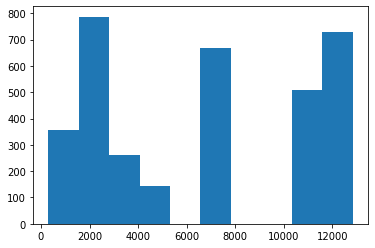

In [104]:
  plt.hist(all_vals)

303 12831
vals [6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6644, 6645, 

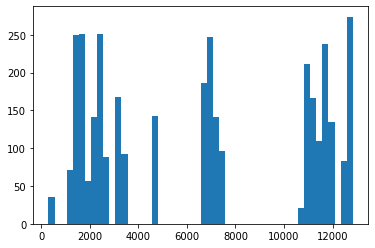

In [118]:
import matplotlib.pyplot as plt
id_window_trigger = True

if id_window_trigger:

  # Element to test on
  element_id = 3

  ## Want to find the contracts that actually have this element
  elem_contracts, elem_docs = get_contracts_docs_with_element(contracts, docs, element_id)

  curr_min = 999999999
  curr_max = 0 

  all_vals = []

  for i,c in enumerate(elem_contracts):
    doc = elem_docs[i]
    #answer_span = get_labels(c, element_id, doc)

    qa = c['qas'][element_id]

    # Get the span of the answer tokens
    # Concatenate together so we have a list of tokens that are part of the label
    answers = qa['answers']
    answer_spans = get_answer_spans(doc, answers)
    concat_ans_spans = np.concatenate(answer_spans) if len(answer_spans) > 0 else []

    #print(concat_ans_spans)
    all_vals.extend(concat_ans_spans)

    curr_min = min(curr_min, min(concat_ans_spans, default=9999999))
    curr_max = max(curr_max, max(concat_ans_spans, default=0))

  print(curr_min, curr_max)

  print('vals',all_vals)
  plt.hist(all_vals, bins=50)

# Results (token window)
## 0: 0 15639... search 0 -1000
## 1: 0 17426... search 0 - 2000
## 2: 0 12899... search 0 - 1000
## 3: 303 12831... search 300 - 12831 - damn. they're everywhere
## 4: 401 15333... search 400 - 12000



In [166]:
doc_ranges = [
  [0,1000],
  [0,1600],
  [0,3000],
  [300,13000],
  [400,12000]
]

# Element to test on
element_id = 4

## Want to find the contracts that actually have this element
elem_contracts, elem_docs = get_contracts_docs_with_element(contracts, docs, element_id)

doc_range = doc_ranges[element_id]

labels = []

for i, contract in enumerate(elem_contracts):
  doc = elem_docs[i]
  doc_sub = doc[doc_range[0]: doc_range[1]]
  
  next_labels = get_labels(contract, element_id, doc_sub)
    
  labels.extend(next_labels)

print(len(labels))

# now get unique
u,c = np.unique(labels, return_counts=True)
print(u,c, sum(c), c[1]*100/sum(c))
print(sum(c), c[1], round(100*c[1]/sum(c),3))

1124338
[0 1] [1108242   16096] 1124338 1.4315979714285205
1124338 16096 1.432
